#Lab Objectives
* Build an autoencoder model for image compression.



In [ ]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.datasets import fashion_mnist
import keras
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(1337)

## Dataset

We will use the [Fashion_Mnist] which contains 60,000 training images and 10,000 testing images.


In [ ]:

(x_train, _), (x_test, _) = fashion_mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

## Normalize the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [ ]:
# summarize the shape of the dataset
print('Train', x_train.shape)
print('Test', x_test.shape)

Train (60000, 28, 28, 1)
Test (10000, 28, 28, 1)


In [ ]:
noise = np.random.normal(loc=0.5, scale=0.3, size=x_train.shape)
x_train_noisy = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.3, size=x_test.shape)
x_test_noisy = x_test + noise

# Clip the images to be between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Let's take a look at some of the data.

In [ ]:
input = Input(shape=(28, 28, 1), name='encoder_input')

x = Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = MaxPooling2D((2, 2), padding="same")(x)
x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
encoded = MaxPooling2D((2, 2), padding="same")(x)


In [ ]:
x = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(encoded)
x = Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x) # Why?

In [ ]:
autoencoder = Model(input, decoded)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 32)       9248  

In [ ]:
autoencoder.fit(x = x_train_noisy,
                y = x_train,
                validation_split = 0.2,
                # validation_date = (x_test, x_test_noisy),
                epochs=100,
                shuffle = True,
                batch_size=128)

Epoch 1/100
375/375 [==============================] - 15s 9ms/step - loss: 0.3620 - val_loss: 0.3097
Epoch 2/100
375/375 [==============================] - 3s 9ms/step - loss: 0.3034 - val_loss: 0.3009
Epoch 3/100
375/375 [==============================] - 4s 11ms/step - loss: 0.2977 - val_loss: 0.2973
Epoch 4/100
375/375 [==============================] - 3s 8ms/step - loss: 0.2943 - val_loss: 0.2944
Epoch 5/100
375/375 [==============================] - 3s 7ms/step - loss: 0.2919 - val_loss: 0.2933
Epoch 6/100
375/375 [==============================] - 3s 9ms/step - loss: 0.2898 - val_loss: 0.2912
Epoch 7/100
375/375 [==============================] - 3s 8ms/step - loss: 0.2883 - val_loss: 0.2892
Epoch 8/100
375/375 [==============================] - 3s 7ms/step - loss: 0.2869 - val_loss: 0.2878
Epoch 9/100
375/375 [==============================] - 3s 8ms/step - loss: 0.2860 - val_loss: 0.2869
Epoch 10/100
375/375 [==============================] - 3s 8ms/step - loss: 0.2850 - val_

313/313 [==============================] - 1s 2ms/step


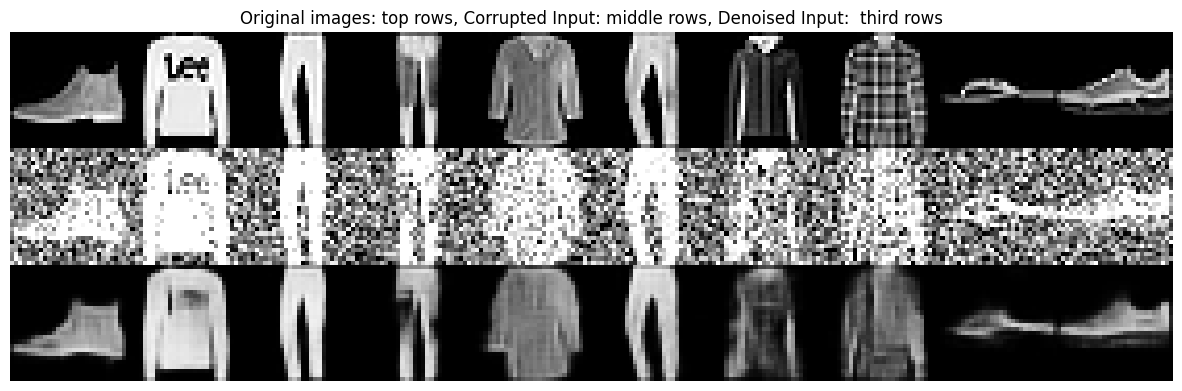

In [ ]:
# Predict the Autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

# Display the 1st 10 corrupted and denoised images
rows, cols = 1, 10
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num], x_decoded[:num]])
imgs = imgs.reshape((rows * 3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows * 3, -1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs * 255).astype(np.uint8)
fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(15)
plt.axis('off')
plt.title('Original images: top rows, '
          'Corrupted Input: middle rows, '
          'Denoised Input:  third rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('corrupted_and_denoised.png')
plt.show()